In [100]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import os
import pickle
warnings.simplefilter("ignore")

In [2]:
from scipy import signal
from scipy import interpolate
from scipy.fft import fft, ifft
from scipy.signal import stft

# Sample Data

In [3]:
path = '../data/CPC 주조조건 데이터(4月)/CM7/20230401~20230410_CM7.xlsx'
all_df = pd.read_excel(path)
all_df['cnt_time'] = all_df['cnt_time'].apply(lambda x: int(x/1000))

In [4]:
all_df

,idx,ae_name,cnt_name,cnt_data,cnt_time
0,7.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,73.0,1680274799
1,113.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,75.0,1680274801
2,116.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT,738.3,1680274801
3,296.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,77.0,1680274803
4,300.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT,738.4,1680274803
...,...,...,...,...,...
1045227,372426.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,268.0,1681138789
1045228,372544.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP,0.0,1681138790
1045229,372540.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,270.0,1681138790
1045230,372688.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,271.0,1681138791


In [5]:
all_df['cnt_datetime'] = all_df['cnt_time'].apply(lambda x: datetime.utcfromtimestamp(int(x)))

1. 사이클타임 : COM_PV_ALT
2. 작업수량 : COM_PV_CC
3. 보온로 압력 : COM_PV_FP
4. 용탕온도 : COM_PV_FT
5. 공압센서 : CAST_OUT_ACTION_TO_PQ_VAL
6. 챔버압력 : COM_PV_CP

In [6]:
all_df.head(5)

,idx,ae_name,cnt_name,cnt_data,cnt_time,cnt_datetime
0,7.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,73.0,1680274799,2023-03-31 14:59:59
1,113.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,75.0,1680274801,2023-03-31 15:00:01
2,116.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT,738.3,1680274801,2023-03-31 15:00:01
3,296.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,77.0,1680274803,2023-03-31 15:00:03
4,300.0,PLC_CPC_LineB,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT,738.4,1680274803,2023-03-31 15:00:03


In [7]:
set(all_df['cnt_name'])

{'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL',
 'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT',
 'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CC',
 'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP',
 'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP',
 'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT'}

In [8]:
df = all_df[['cnt_name','cnt_data','cnt_time']].drop_duplicates()

In [9]:
df = df.groupby(['cnt_time','cnt_name']).mean().reset_index()

# Pivot Table

In [10]:
df_pivot = df.pivot(index='cnt_time', columns='cnt_name', values='cnt_data')

In [11]:
df_pivot

cnt_name,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CC,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP,CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT
cnt_time,,,,,,
1680274799,NaN,73.0,NaN,NaN,NaN,NaN
1680274801,NaN,75.0,NaN,NaN,NaN,738.3
1680274803,NaN,77.0,NaN,NaN,NaN,738.4
1680274804,NaN,78.0,NaN,NaN,1235.0,NaN
1680274805,0.0,80.0,NaN,719.0,1234.0,738.5
...,...,...,...,...,...,...
1681138787,NaN,267.0,NaN,NaN,NaN,723.8
1681138789,NaN,268.0,NaN,NaN,1.0,NaN
1681138790,NaN,270.0,NaN,NaN,0.0,NaN


In [12]:
np.arange(df_pivot.index[0], df_pivot.index[-1]+1, 1)

array([1680274799, 1680274800, 1680274801, ..., 1681138793, 1681138794,
       1681138795], dtype=int64)

In [25]:
def get_pivot_table(path):
    all_df = pd.read_excel(path)
    all_df['cnt_time'] = all_df['cnt_time'].apply(lambda x: int(x/1000))
    all_df['cnt_datetime'] = all_df['cnt_time'].apply(lambda x: datetime.utcfromtimestamp(int(x)))
    df = all_df[['cnt_name','cnt_data','cnt_time']].drop_duplicates()
    df = df.groupby(['cnt_time','cnt_name']).mean().reset_index()
    df_pivot = df.pivot(index='cnt_time', columns='cnt_name', values='cnt_data')
    return df_pivot

In [56]:
def get_column_names(df):
    column_names = dict()
    columns = df.columns
    for c in ['VAL', 'ALT', 'CC', 'CP', 'FP', 'FT']:
        column_names[c] = [x for x in columns if c in x][0]
    column_names['CM'] = columns[0].split('.')[-2]
    return column_names

In [39]:
df_pivot.columns

Index(['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL',
       'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT',
       'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CC',
       'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP',
       'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP',
       'CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT'],
      dtype='object', name='cnt_name')

# Visualization & Cycle Extraction

In [13]:
fp = all_df[all_df['cnt_name']=="CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP"]

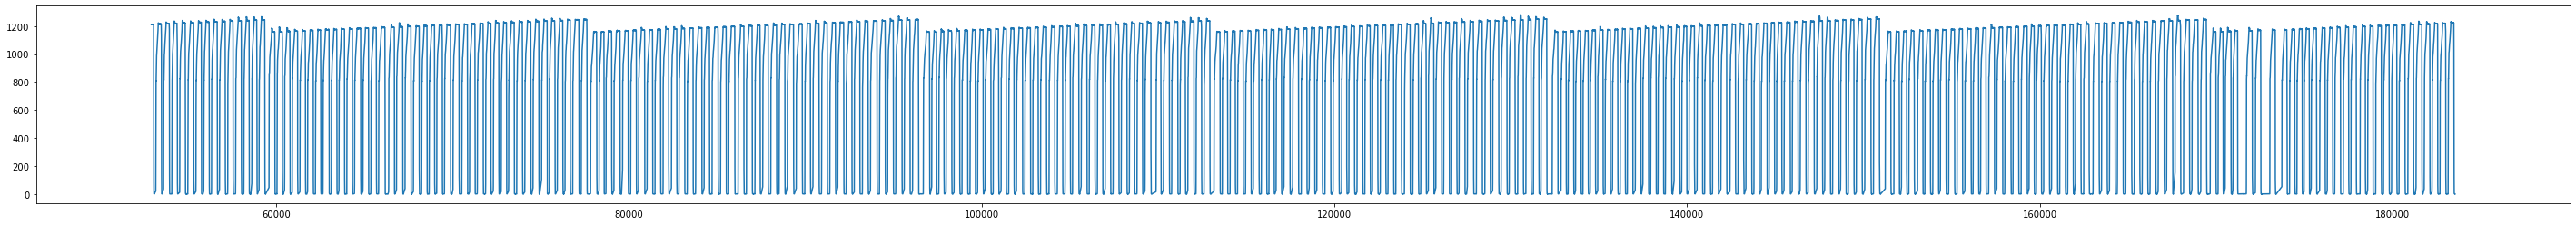

In [14]:
plt.figure(figsize=(50,4))
plt.plot(fp[(fp["cnt_datetime"]>"2023-04-01") * (fp["cnt_datetime"]<"2023-04-02")]["cnt_data"])

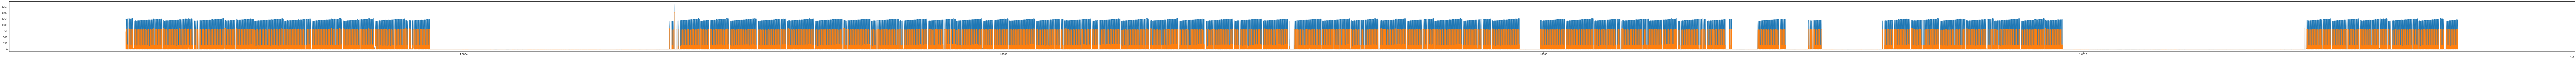

In [15]:
plt.figure(figsize=(200,4))
plt.plot(df_pivot['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna())
plt.plot(df_pivot['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna())

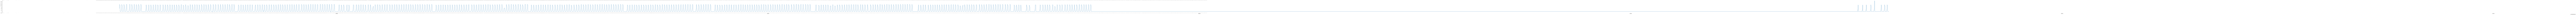

In [16]:
plt.figure(figsize=(800,4))
plt.plot((df_pivot['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna() - df_pivot['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna()).dropna()[:30000])

In [17]:
from scipy.signal import find_peaks
df_alt = df_pivot['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_ALT'].dropna()
peaks, _ = find_peaks(df_alt, height=200)
peaks_inverse, _ = find_peaks(-df_alt, height=-200)

In [18]:
starting_times = df_alt.iloc[peaks_inverse][df_alt.iloc[peaks_inverse]<25]
ending_times = df_alt.iloc[peaks]

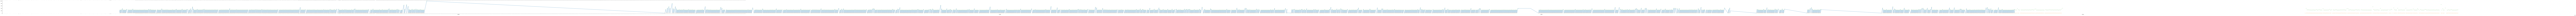

In [19]:
plt.figure(figsize=(750,4))
plt.plot(df_alt)
plt.plot(starting_times, "x")
plt.plot(ending_times, "x")

In [20]:
cycle_timestamps = []
cycle_time_duration = []
for s in starting_times.index:
    try:
        e = ending_times.index[ending_times.index > s][0]
        cycle_timestamps.append((s, e))
        cycle_time_duration.append((e - s))
    except:
        pass

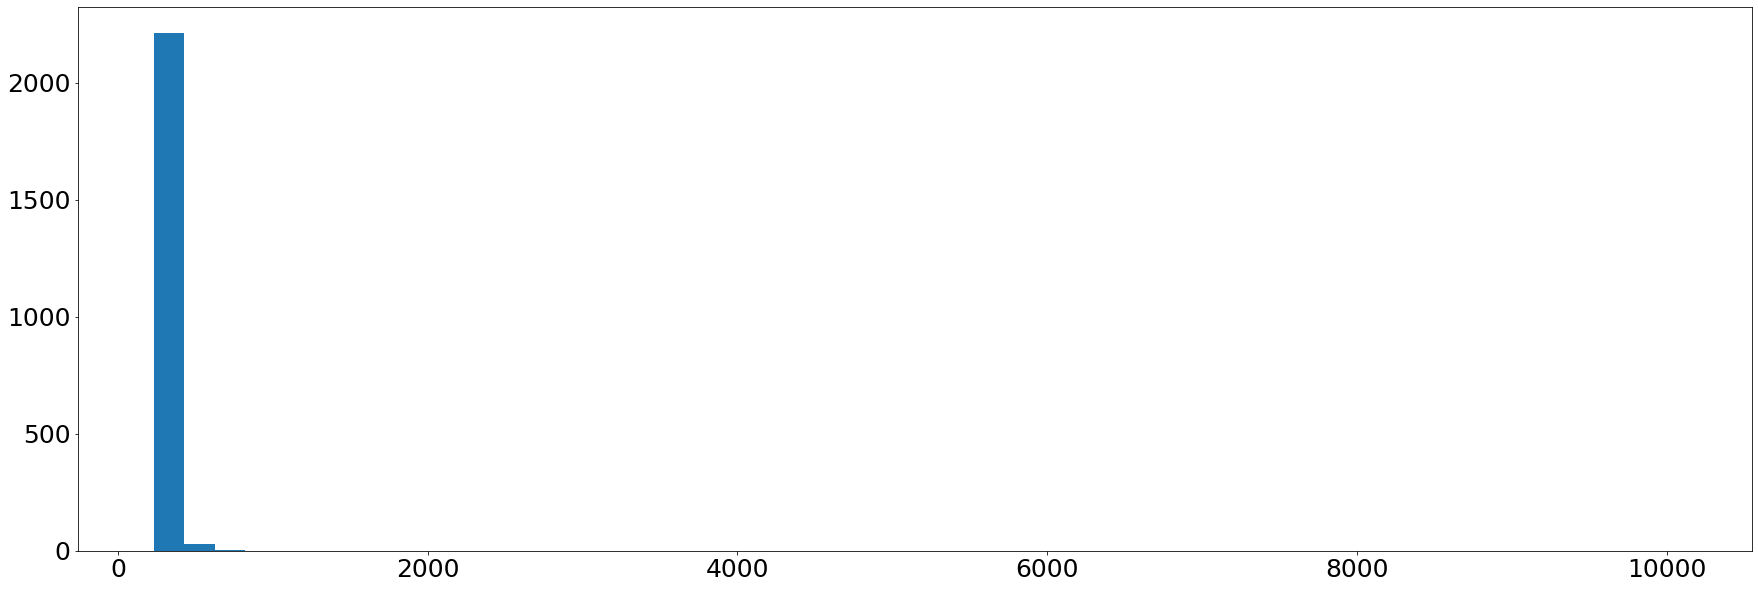

In [21]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 25})
plt.hist(cycle_time_duration, bins=50)
plt.show()
plt.rcParams.update({'font.size': 10})

In [96]:
def get_cycles(df, column_names):
    df_alt = df[column_names['ALT']].dropna()
    peaks, _ = find_peaks(df_alt, height=200)
    peaks_inverse, _ = find_peaks(-df_alt, height=-200)
    starting_times = df_alt.iloc[peaks_inverse][df_alt.iloc[peaks_inverse]<25]
    ending_times = df_alt.iloc[peaks]
    
    cycle_timestamps = []
    for s in starting_times.index:
        try:
            e = ending_times.index[ending_times.index > s][0]
            cycle_timestamps.append((s, e))
        except:
            pass
    return cycle_timestamps

# 가열로 압력 Sample Signal 분석

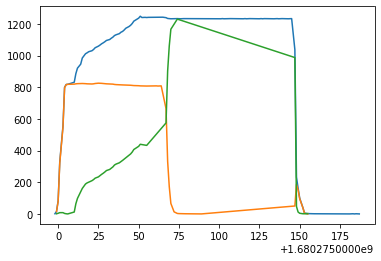

In [22]:
sample_signal = df_pivot.loc[cycle_timestamps[0][0] : cycle_timestamps[0][1]]
plt.plot(sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna())
plt.plot(sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna())
plt.plot((sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna() - sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna()).dropna())

In [23]:
x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna().index
x_new = np.arange(x[0], x[-1] + 1, 1)
y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna()
interpolation = interpolate.interp1d(x, y, kind='linear')
y_new_fp = interpolation(x_new)

x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna().index
x_new = np.arange(x[0], x[-1] + 1, 1)
y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna()
interpolation = interpolate.interp1d(x, y, kind='linear')
y_new_cp = interpolation(x_new)

NameError: name 'y_new' is not defined

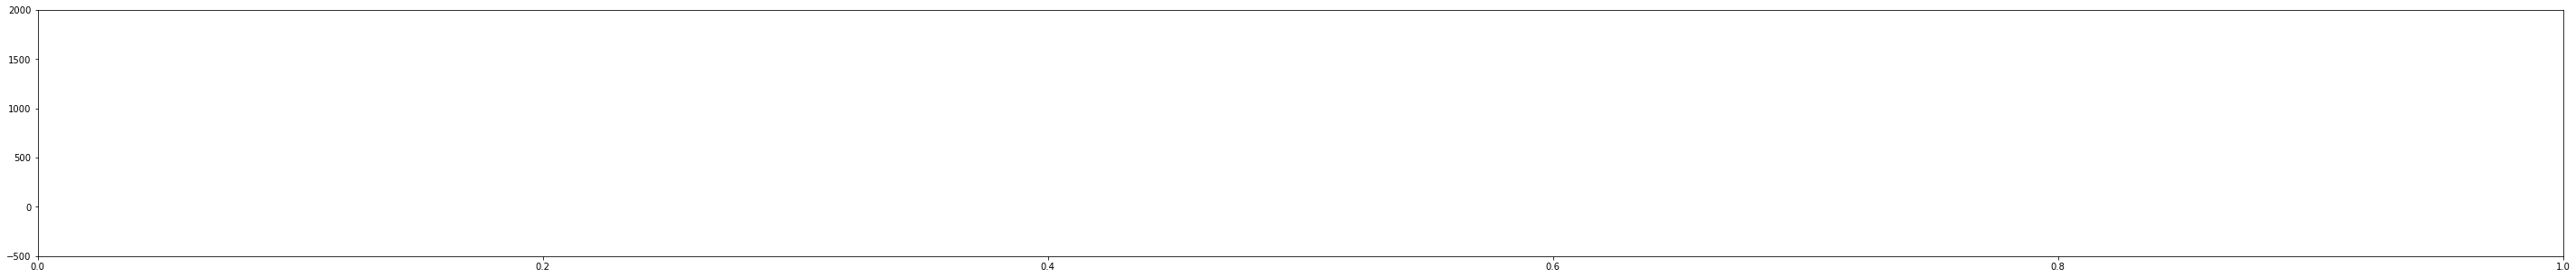

In [24]:
plt.figure(figsize=(50, 5))
plt.ylim(-500, 2000)
peaks, _ = find_peaks(y_new, prominence=(0.4,1.2))
plt.plot(y_new, 'o')
plt.plot(peaks, y_new[peaks], "x")
plt.plot(np.append([0], (np.diff(y_new, n=2))))
#plt.plot(np.argmax(y_new), np.max(y_new), 'x')

In [ ]:
for i in range(100):
    sample_signal = df_pivot.loc[cycle_timestamps[i][0] : cycle_timestamps[i][1]]
    """
    plt.plot(sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna())
    plt.show()
    plt.plot(sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna())
    plt.show()
    """
    #plt.plot((sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna() - sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna()).dropna())
    #plt.show()
    
    x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna().index
    x_new = np.arange(x[0], x[-1] + 1, 1)
    y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna()
    interpolation = interpolate.interp1d(x, y, kind='linear')
    fp_interpolate = interpolation(x_new)
    fp_interpolate = np.pad(fp_interpolate, (0, 1000 - len(fp_interpolate)))[:200]
    
    x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna().index
    x_new = np.arange(x[0], x[-1] + 1, 1)
    y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_CP'].dropna()
    interpolation = interpolate.interp1d(x, y, kind='linear')
    cp_interpolate = interpolation(x_new)
    cp_interpolate = np.pad(cp_interpolate, (0, 1000 - len(cp_interpolate)))[:200]
    
    plt.figure(figsize=(10, 6))
    plt.ylim(-250, 1500)
    #plt.plot(fp_interpolate)
    #plt.plot(cp_interpolate)
    plt.plot(fp_interpolate - cp_interpolate)
    #plt.plot(np.append([0], (np.diff(y_new, n=2))))
    #plt.plot(np.argmax(y_new), np.max(y_new), 'x')
    plt.show()

In [ ]:
len(np.pad(cp_interpolate, (0, len(fp_interpolate) - len(cp_interpolate)))), len(fp_interpolate)

In [66]:
def get_signal_matrix(df_pivot, column_names, cycle_timestamps):
    signals = dict()
    for cycle_timestamp in cycle_timestamps:
        key = f'{column_names["CM"]}_{cycle_timestamp[0]}'
        signal = df_pivot.loc[cycle_timestamp[0] : cycle_timestamp[1]]
        signals[key] = signal
    return signals

# 공압센서

In [ ]:
action_to_pq = df_pivot["CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL"]

In [ ]:
for i in range(20):
    sample_signal = df_pivot.loc[cycle_timestamps[i][0] : cycle_timestamps[i][1]]
    #plt.plot(sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL'].dropna())
    #plt.show()
    #print(len((sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna())))
    
    x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL'].dropna().index
    x_new = np.arange(x[0], x[-1] + 1, 1)
    y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL'].dropna()
    
    interpolation = interpolate.interp1d(x, y, kind='nearest')
    y_new = interpolation(x_new)
    plt.plot(y_new)
    plt.show()

# 용탕온도 + 보온로 압력

In [ ]:
ft = all_df[all_df['cnt_name']=="CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT"]
fp = all_df[all_df['cnt_name']=="CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP"]

In [ ]:
plt.figure(figsize=(100,4))
plt.plot(fp[(fp["cnt_datetime"]>"2023-04-01") * (fp["cnt_datetime"]<"2023-04-02")]["cnt_data"])
plt.plot(ft[(ft["cnt_datetime"]>"2023-04-01") * (ft["cnt_datetime"]<"2023-04-02")]["cnt_data"])

In [ ]:
for i in range(20):
    sample_signal = df_pivot.loc[cycle_timestamps[i][0] : cycle_timestamps[i][1]]
    #plt.plot(sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL'].dropna())
    #plt.show()
    #print(len((sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna())))
    
    x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT'].dropna().index
    x_new = np.arange(x[0], x[-1] + 1, 1)
    y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FT'].dropna()
    interpolation = interpolate.interp1d(x, y, kind='linear')
    y_new = interpolation(x_new)
    plt.plot(y_new)
    
    x = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna().index
    x_new = np.arange(x[0], x[-1] + 1, 1)
    y = sample_signal['CPC_LineB.CPC_PLCB.Global.CM7_DATA_x.COM_PV_FP'].dropna()
    interpolation = interpolate.interp1d(x, y, kind='linear')
    y_new = interpolation(x_new)
    plt.plot(y_new)
    
    plt.show()

# 데이터 수합

In [26]:
df_pivot = get_pivot_table('../data/CPC 주조조건 데이터(4月)/CM7/20230401~20230410_CM7.xlsx')

In [57]:
column_names = get_column_names(df_pivot)

In [47]:
cycles = get_cycles(df_pivot, column_names)

In [67]:
signals = get_signal_matrix(df_pivot, column_names, cycles)

In [94]:
def preprocess(paths):
    data = dict()
    for path in paths:
        print(path)
        df_pivot = get_pivot_table(path)
        column_names = get_column_names(df_pivot)
        cycles = get_cycles(df_pivot, column_names)
        signals = get_signal_matrix(df_pivot, column_names, cycles)
        data = {**data, **signals}
    return data

In [92]:
root = '../data/CPC 주조조건 데이터(4月)'
paths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        paths.append(os.path.join(path, name))

In [97]:
data = preprocess(paths)

../data/CPC 주조조건 데이터(4月)\CM7\20230401~20230410_CM7.xlsx
../data/CPC 주조조건 데이터(4月)\CM7\20230411~20230415_CM7.xlsx
../data/CPC 주조조건 데이터(4月)\CM7\20230416~20230420_CM7.xlsx
../data/CPC 주조조건 데이터(4月)\CM7\20230421~20230425_CM7.xlsx
../data/CPC 주조조건 데이터(4月)\CM7\20230426~20230430_CM7.xlsx
../data/CPC 주조조건 데이터(4月)\CM8\20230401~20230410_CM8.xlsx
../data/CPC 주조조건 데이터(4月)\CM8\20230411~20230420_CM8.xlsx
../data/CPC 주조조건 데이터(4月)\CM8\20230421~20230430_CM8.xlsx
../data/CPC 주조조건 데이터(4月)\CM9\20230401~20230405_CM9.xlsx
../data/CPC 주조조건 데이터(4月)\CM9\20230406~20230410_CM9.xlsx
../data/CPC 주조조건 데이터(4月)\CM9\20230411~20230415_CM9.xlsx
../data/CPC 주조조건 데이터(4月)\CM9\20230416~20230420_CM9.xlsx
../data/CPC 주조조건 데이터(4月)\CM9\20230421~20230425_CM9.xlsx
../data/CPC 주조조건 데이터(4月)\CM9\20230426~20230430_CM9.xlsx


In [102]:
with open('myunghwa_cpc_202304.pickle', 'wb') as f:
    pickle.dump(data, f)

In [105]:
len(data)

21032

In [ ]:
label['CM7_DATA_x_1680274998']